# Import Library

In [1]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Downloading Dataset

In [2]:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
url = 'https://drive.google.com/file/d/1aX4pxw4KsGbhz3ZP9STm0xfN4HyuN8cy/view?usp=sharing'
# Split link to get ID
split1 = url.split('d/')[1]
id = split1.split('/view?')[0]
print(id)

1aX4pxw4KsGbhz3ZP9STm0xfN4HyuN8cy


In [5]:
# Downloading file
file = drive.CreateFile({'id':id})
file.GetContentFile('Sidewalk_Object_Dataset.zip')

In [6]:
fzip = 'Sidewalk_Object_Dataset.zip'
zip_ref = zipfile.ZipFile(fzip, 'r')
zip_ref.extractall('./SidewalkDataset')
zip_ref.close()

# Image Augmentation

In [7]:
train_dir = '/content/SidewalkDataset/train'
val_dir = '/content/SidewalkDataset/val'

In [8]:
def train_val_generators(training_dir, validation_dir):
  train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      directory=train_dir,
      batch_size=64,
      class_mode='categorical',
      target_size=(150, 150)
  )
  
  val_datagen = ImageDataGenerator(rescale=1/255)

  val_generator = val_datagen.flow_from_directory(
      directory=val_dir,
      batch_size=64,
      class_mode='categorical',
      target_size=(150, 150)
  )

  return train_generator, val_generator

In [9]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 2254 images belonging to 9 classes.
Found 466 images belonging to 9 classes.


In [10]:
train_generator.class_indices

{'Bench': 0,
 'Bicycle': 1,
 'Car': 2,
 'Flowerpot': 3,
 'Motorcycle': 4,
 'Person': 5,
 'Pole': 6,
 'Potholes': 7,
 'Truck': 8}

In [11]:
validation_generator.class_indices

{'Bench': 0,
 'Bicycle': 1,
 'Car': 2,
 'Flowerpot': 3,
 'Motorcycle': 4,
 'Person': 5,
 'Pole': 6,
 'Potholes': 7,
 'Truck': 8}

In [12]:
class_names = []
for category in train_generator.class_indices:
  class_names.append(category)

# Transfer Learning: InceptionV3

In [13]:
# Download the pre-trained weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-11 07:34:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   169MB/s    in 0.5s    

2022-06-11 07:34:19 (169 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [14]:
# Import model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Set the weights file
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(input_shape=(150,150,3),
                               include_top = False,
                               weights = None)

# Load the pre-trained weights
pretrained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pretrained_model.layers:
  layer.trainable = False

In [15]:
# Choose 'mixed_7' as the last layer of base model
last_layer = pretrained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [16]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final softmax layer for classification
x = tf.keras.layers.Dense(9, activation='softmax')(x)           

# Append the dense network to the base model
model = tf.keras.Model(pretrained_model.input, x) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/20
 7/36 [====>.........................] - ETA: 39s - loss: 4.0483 - accuracy: 0.4464

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/36 [==============================] - 78s 2s/step - loss: 1.2189 - accuracy: 0.7888 - val_loss: 0.3018 - val_accuracy: 0.9399
Epoch 2/20
36/36 [==============================] - 68s 2s/step - loss: 0.3076 - accuracy: 0.9166 - val_loss: 0.2517 - val_accuracy: 0.9270
Epoch 3/20
36/36 [==============================] - 67s 2s/step - loss: 0.2048 - accuracy: 0.9397 - val_loss: 0.2083 - val_accuracy: 0.9485
Epoch 4/20
36/36 [==============================] - 67s 2s/step - loss: 0.2076 - accuracy: 0.9343 - val_loss: 0.1907 - val_accuracy: 0.9464
Epoch 5/20
36/36 [==============================] - 67s 2s/step - loss: 0.1793 - accuracy: 0.9468 - val_loss: 0.1448 - val_accuracy: 0.9614
Epoch 6/20
36/36 [==============================] - 66s 2s/step - loss: 0.1508 - accuracy: 0.9508 - val_loss: 0.1655 - val_accuracy: 0.9485
Epoch 7/20
36/36 [==============================] - 66s 2s/step - loss: 0.1464 - accuracy: 0.9552 - val_loss: 0.1953 - val_accuracy: 0.9356
Epoch 8/20
36/36 [=============

# Plotting Accuracy and Loss

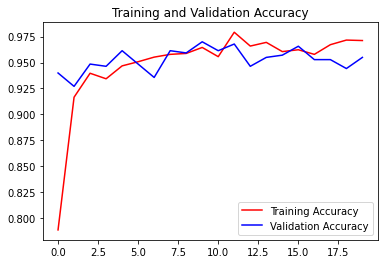

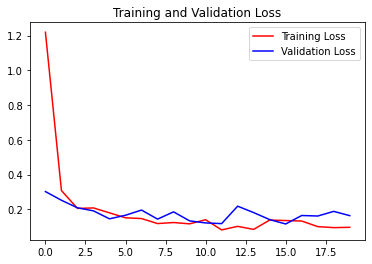

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

# Loss
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Export Model

In [20]:
# Save model to h5 format
model.save('sidewalk_obj_inceptionV3.h5')

In [21]:
export_dir = 'saved_model/inception'
tf.saved_model.save(model, export_dir=export_dir)


INFO:tensorflow:Assets written to: saved_model/inception/assets


In [22]:
# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = "sidewalk_obj_inceptionV3.tflite"

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('sidewalk_obj_inceptionV3.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [23]:
from google.colab import files
try:
    files.download('sidewalk_obj_inceptionV3.tflite')
    files.download('sidewalk_obj_inceptionV3.h5')
    files.download('sidewalk_obj_inceptionV3.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>